In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Collab-Datasets/nasd_query.csv'
DATASET_SIZE = 3
LAG = 20

In [4]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [5]:
mu = None
sigma = None
def normalize(dataset):
  return (dataset - mu)/sigma 

def reverse_normalize(dataset):
  return dataset*sigma + mu 

def preprocess_dataset(df, lag=1):
  global sigma
  global mu
  dataset = df.to_numpy()
  
  if sigma is None: sigma = dataset.std()
  if mu is None: mu = dataset.mean()

  dataset = normalize(dataset)
  # divide the time series in input instances of X: #lag steps y: #lag+1-th value of the time series 
  # so we acquire #df * (complexity(df)-lag)
  X = None
  y = None
  for timeseries in dataset:
    X_i = None
    y_i = None 
    for i in range(lag, len(timeseries)):
      X_ij = np.asarray(timeseries[i-lag:i]).reshape((1, len(timeseries[i-lag:i]), 1))
      X_i = np.concatenate((X_i, X_ij)) if X_i is not None else X_ij
      y_ij = np.asarray(timeseries[i]).reshape((-1, 1))
      y_i = np.concatenate((y_i, y_ij)) if y_i is not None else y_ij
    
    X = np.concatenate((X, X_i), axis=-1) if X is not None else X_i
    y = np.concatenate((y, y_i), axis=-1) if y is not None else y_i

  return train_test_split(X, y, test_size=0.2)

In [6]:
X_train, X_val, y_train, y_val = preprocess_dataset(timeseries_df, lag=LAG)

In [7]:
class TimeSeriesForecast():
  def __init__(self, input_dim, lstm_units, dropout=None, _optimizer='adam', _loss='mse'):
    self.history = None
    self.D_train = None
    self.D_test = None
    self.lstm_units = lstm_units
    self.dropout = dropout
    self.optimizer = _optimizer
    self.loss = _loss
    self.input_dim = input_dim

    # create the model architecture
    self.model = models.Sequential()
    for i, u in enumerate(self.lstm_units):
      if i == 0: 
        self.model.add(layers.LSTM(units=u, return_sequences=True, input_shape=self.input_dim))
      elif i == len(self.lstm_units) - 1:
        self.model.add(layers.LSTM(units=u))
      else: 
        self.model.add(layers.LSTM(units=u, return_sequences=True))
      if self.dropout is not None:
        self.model.add(layers.Dropout(self.dropout))

    # final output layer
    self.model.add(layers.Dense(input_dim[-1]))
    
    self.model.compile(optimizer=self.optimizer, loss=self.loss)

  def fit(self, X, y, epochs=100, batch_size=128):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    self.D_train = X_train, y_train
    self.D_test = X_test, y_test
    self.history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    return self.history

  def predict(self, X):
    return self.model.predict(X)

  def evaluate(self, X, y_true):
    """The evaluate function will print a graph of all """
    return self.model.evaluate(X, y_true, batch_size=64)

In [8]:
model = TimeSeriesForecast(X_train.shape[1:], [50, 50,100], dropout=0.3)

In [9]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
3/3 [==============================] - 17s 1s/step - loss: 0.9449 - val_loss: 0.5893
Epoch 2/50
3/3 [==============================] - 0s 52ms/step - loss: 0.4573 - val_loss: 0.1455
Epoch 3/50
3/3 [==============================] - 0s 86ms/step - loss: 0.1406 - val_loss: 0.1682
Epoch 4/50
3/3 [==============================] - 0s 64ms/step - loss: 0.1826 - val_loss: 0.0754
Epoch 5/50
3/3 [==============================] - 0s 75ms/step - loss: 0.0917 - val_loss: 0.0648
Epoch 6/50
3/3 [==============================] - 0s 71ms/step - loss: 0.0952 - val_loss: 0.0691
Epoch 7/50
3/3 [==============================] - 0s 72ms/step - loss: 0.0861 - val_loss: 0.0398
Epoch 8/50
3/3 [==============================] - 0s 78ms/step - loss: 0.0523 - val_loss: 0.0105
Epoch 9/50
3/3 [==============================] - 0s 79ms/step - loss: 0.0382 - val_loss: 0.0187
Epoch 10/50
3/3 [==============================] - 0s 78ms/step - loss: 0.0457 - val_loss: 0.0192
Epoch 11/50
3/3 [=============

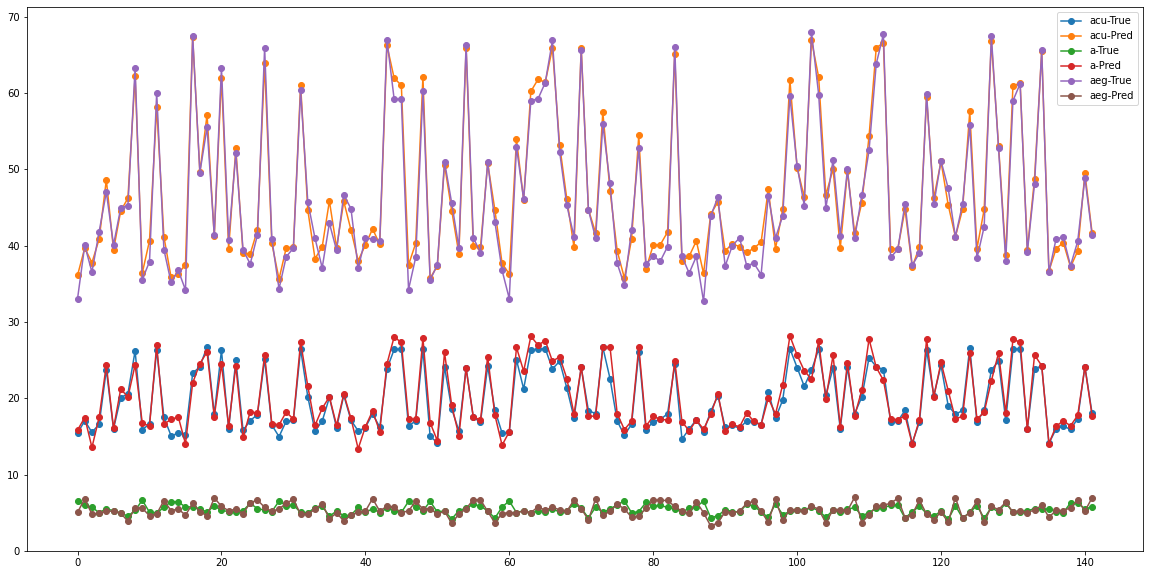

In [24]:
y_pred = reverse_normalize(model.predict(X_val))
figure(figsize=(20, 10))
lgnd = []
plt.plot(np.arange(0, len(y_pred)), y_pred, 'o-')
plt.plot(np.arange(0, len(y_val)), reverse_normalize(y_val), 'o-')

for i, id in enumerate(TIME_SERIES_ID):
  lgnd += [f'{id}-True',f'{id}-Pred']

plt.legend(lgnd)
plt.show()